# Dragut 2019 – empirical curve (retail phone regex)

Baseline: simple phone-number regex, labels revealed in 5-minute blocks.

In [16]:
# --- Imports and data load ---------------------------------------------------
import pandas as pd, pathlib, os, sys, re, json, numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

ROOT = pathlib.Path(os.getcwd()).parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))          # make "src" importable

RAW = ROOT / "data" / "raw" / "dragut_phone.csv"
df  = pd.read_csv(RAW)

In [17]:
# 1) Label with the simple phone-number regex
phone_pat = re.compile(r"\(?\d{3}\)?[-\s]\d{3}-\d{4}")
y_true = df["Label"].values
y_pred = df["String"].str.contains(phone_pat).astype(int).values

In [18]:
# 2) Build F1 vs annotation-minutes curve (5-minute granularity)
f1_points = []
minutes_per_row = 2          # ≈30 rows / hour
for m in range(0, 160, 5):
    rows = int(m / minutes_per_row)
    if rows == 0:
        f1 = 0.0
    else:
        f1 = precision_recall_fscore_support(
            y_true[:rows], y_pred[:rows],
            average="binary", zero_division=0
        )[2]
    f1_points.append((m, f1))

m_values, f1_values = zip(*f1_points)      #  <-- this is the X list

In [19]:
# 3) Fit the 2-parameter log curve you already implemented
from src.curves import fit_log_curve, log_model   # your helper functions
a, b, rmse = fit_log_curve(m_values, f1_values)

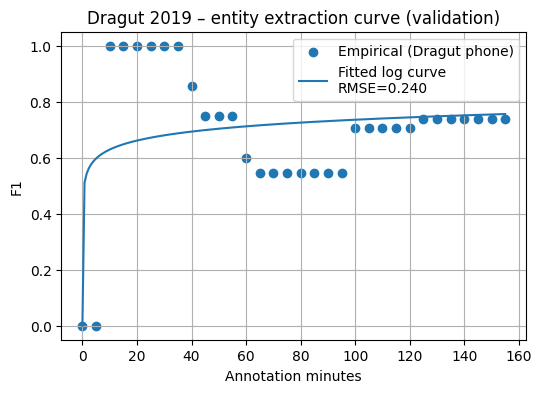

Fitted  a=0.046, b=80419.0618,  RMSE=0.2404


In [20]:
# 4) Plot + save
plt.figure(figsize=(6,4))
plt.scatter(m_values, f1_values, label="Empirical (Dragut phone)")
m_plot = np.linspace(0, max(m_values), 200)
plt.plot(m_plot, log_model(m_plot, a, b),
         label=f"Fitted log curve\nRMSE={rmse:.3f}")
plt.title("Dragut 2019 – entity extraction curve (validation)")
plt.xlabel("Annotation minutes");  plt.ylabel("F1")
plt.legend(); plt.grid(True)
FIG = ROOT / "docs" / "figures" / "dragut_validate.png"
FIG.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(FIG, dpi=120)
plt.show()

print(f"Fitted  a={a:.3f}, b={b:.4f},  RMSE={rmse:.4f}")

In [23]:
# 5) Persist parameters in data/curves.json
CURVES = ROOT / "data" / "curves.json"
curves = json.loads(CURVES.read_text())
curves["Dragut2019_phone"] = {"a": float(a), "b": float(b), "rmse": float(rmse)}
CURVES.write_text(json.dumps(curves, indent=2))
print("Saved →", CURVES)

Saved → c:\Users\zuzia\OneDrive - Temple University\Documents\MS Computational DS\Summer 2025\Research\Project\cost-utility-calculator\data\curves.json
